# Numerically minimising Pauli-weight

One frequently cited goal when designing an encoding $\mathcal{E}$ is to minimise the average number of Pauli-operators in the terms of the qubit Hamiltonian.

This can be done in a _Hamiltonian independent_ way, by considering the set of majorana operators $\set{\gamma}$. With $P(x)$ being the Pauli-weight of $x$,

$$P_{HI}(\mathcal{E}) = \frac{\sum_{\{\gamma\}}{P(\gamma_i)}}{|\set{\gamma}|}$$

If we have a specific Hamiltonian in mind, say the electronic structure hamiltonian, we can be more specific by finding the Pauli weight the set of Hamiltonian terms $\{h\}$ which result from encoding terms of the fermionic Hamiltonian ($a_i^{\dagger}a_j$ and $a_i^{\dagger}a_j^{\dagger}a_k a_l$). 

Note that we don't need to consider the Hamiltonian coefficents $\{\alpha_{i,j}, \alpha_{i,j,k,l}\}$ associated to each of those operators, so this Pauli-weight is _system independent_.

$$P_{HD}(\mathcal{E}, H_F) = \frac{\sum_{\set{h}}P(h)}{|\set{h}|}$$

When considering a real system (such as a water molecule in STO-3G), many of the terms of the fermionic Hamiltonian will represent transitions which are not allowed. As a result, some terms of the general qubit Hamiltonian will not be needed. 

This isn't the end of the story however, because the specific set of qubit operator terms which have non-zero coefficients depends on the enumeration scheme $f$ used in the encoding $\mathcal{E}_{f}$. Accounting for this, we have the _system dependent_ Pauli-weight:

$$P_{SD}(\mathcal{E}_{f}, H_F) = \frac{\sum_{h\in H_Q}P(h)}{|H_Q|}$$


First we'll import data we need specific to the water molecule in $STO-3G$.

In [1]:
import pickle
from pytest import fixture
from ferrmion.encode import TernaryTree, MaxNTO
from pathlib import Path

def water_integrals():
    folder = Path.cwd().joinpath(Path("../../../python/tests/"))
    with open(folder.joinpath("./data/water_1e.pkl"), 'rb') as file:
        ones = pickle.load(file)

    with open(folder.joinpath("./data/water_2e.pkl"), 'rb') as file:
        twos = pickle.load(file)
    return (ones, twos)

tree = TernaryTree(14)

## $P_{HI}$

In [2]:
from ferrmion import FermionQubitEncoding
import numpy as np
def hamiltonian_indpendent_weight(encoding: FermionQubitEncoding):
    _, symplectics = encoding._build_symplectic_matrix()
    x_block, z_block = np.hsplit(symplectics, 2)
    operator_weights = np.sum(np.bitwise_or(x_block, z_block),axis=1)
    return operator_weights

In [3]:
ham_indep = {"jw":None,"pe": None,"bk": None,"jkmn": None}
ham_indep["jw"]=hamiltonian_indpendent_weight(tree.JordanWigner())
ham_indep["pe"]=hamiltonian_indpendent_weight(tree.ParityEncoding())
ham_indep["bk"]=hamiltonian_indpendent_weight(tree.BravyiKitaev())
ham_indep["jkmn"]=hamiltonian_indpendent_weight(tree.JKMN())
ham_indep["MaxNTO"]=hamiltonian_indpendent_weight(MaxNTO(14))

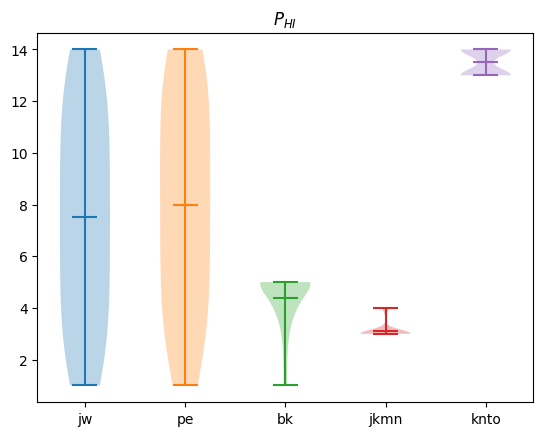

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

#create histogram
n_bins = 30
alpha = 0.7

fig, axs = plt.subplots()
pos = 0
for dist in ham_indep.values():
    axs.violinplot(dist, [pos], showmeans=True)
    pos+=1

axs.set_xticks([*range(len(ham_indep))], labels=ham_indep.keys())
plt.title("$P_{HI}$")
plt.show()

So it seems there is a clear benefit to the multi-branch Bravyi-kitaev and JKMN (minimum height) trees!

Let's move on to see how these encodings behave when applied to the electronic structure Hamiltonian.

## $P_{HD}$

In [5]:
from ferrmion.optimize.enumeration import lambda_plus_mu
from ferrmion.optimize.enumeration.cost_functions import pauli_weighted_norm
from ferrmion.hamiltonians import molecular_hamiltonian_template
from ferrmion.hamiltonians import fill_template
import functools
ones, twos = water_integrals()

templates = {"jw":None,"pe": None,"bk": None,"jkmn": None}

ipowers, symplectics = tree.JW()._build_symplectic_matrix()
templates["jw"] = molecular_hamiltonian_template(ipowers, symplectics, physicist_notation=True)

ipowers, symplectics = tree.ParityEncoding()._build_symplectic_matrix()
templates["pe"] = molecular_hamiltonian_template(ipowers, symplectics, physicist_notation=True)

ipowers, symplectics = tree.BK()._build_symplectic_matrix()
templates["bk"] = molecular_hamiltonian_template(ipowers, symplectics, physicist_notation=True)

ipowers, symplectics = tree.JKMN()._build_symplectic_matrix()
templates["jkmn"] = molecular_hamiltonian_template(ipowers, symplectics, physicist_notation=True)

ipowers, symplectics = MaxNTO(14)._build_symplectic_matrix()
templates["MaxNTO"] = molecular_hamiltonian_template(ipowers, symplectics, physicist_notation=True)

In [6]:
import numpy as np
def template_pauli_weight(template):
    return [len(k) - k.count("I") for k in template.keys()]

ham_dep = {k: template_pauli_weight(v) for k,v in templates.items()}

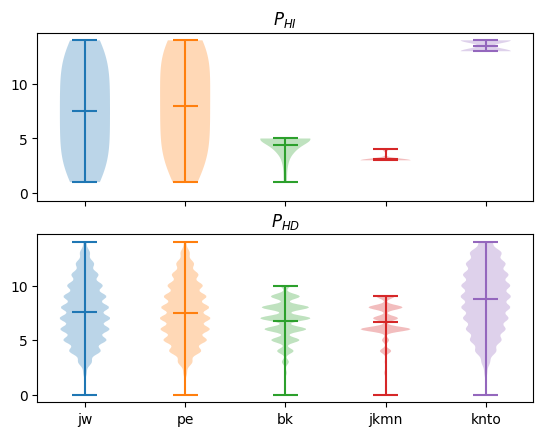

In [7]:
import matplotlib.pyplot as plt

#create histogram
n_bins = 30
alpha = 0.7

fig, axs = plt.subplots(2,1, sharex=True, sharey=True)
pos = 0
for k in ham_dep.keys():
    axs[0].violinplot(ham_indep[k], [pos], showmeans=True)
    axs[1].violinplot(ham_dep[k], [pos], showmeans=True)
    pos+=1
axs[0].title.set_text("$P_{HI}$")
axs[1].title.set_text("$P_{HD}$")
axs[1].set_xticks([*range(len(ham_dep))], labels=ham_dep.keys())
plt.show()

How interesting! The Bravyi-Kitaev and JKMN encodings have lost their advantage now that we're considering the application of encodings to a Hamiltonian.

Conversely, the k-NTO encoding now performs much more similarly to the ternary trees. 

## $P_{SD}$

Let's start by finding $P_{SD}$ for a set of random permutations of the fermionic mode labels.

In [8]:
def fill_template_find_norm(template, ones, twos, permutation):
    permutation = np.array(permutation, dtype=np.uint)
    ham = fill_template(template, 0, ones, 0.5*twos, permutation)
    return pauli_weighted_norm(ham)

As a test, lets check the naive enumeration, $(0,1,...,M) \to (0,1,...,M)$

In [ ]:
naive = {}
for encoding, template in templates.items():
    perm = np.array([*range(14)], dtype=np.uint)
    naive[encoding] = fill_template_find_norm(template, ones, twos, perm)[0]
naive

{'jw': np.float64(191.40252833977175),
 'pe': np.float64(256.99667953199605),
 'bk': np.float64(291.9131210131432),
 'jkmn': np.float64(277.60497673050884),
 'MaxNTO': np.float64(667.3119791169846)}

Now we can run a set of random permutations, there is a helper function `template_weight_distribution` just to make this easier.

Increasing the number of pemutations to try here will take longer but the plots later are more satisfying!

In [ ]:
import numpy as np
from ferrmion.core import template_weight_distribution
distributions = {k: template_weight_distribution(templates[k], 0., ones, 0.5*twos, 100) for k in templates.keys()}

Let's plot these, with the naive enumerations shown as dashed black lines.

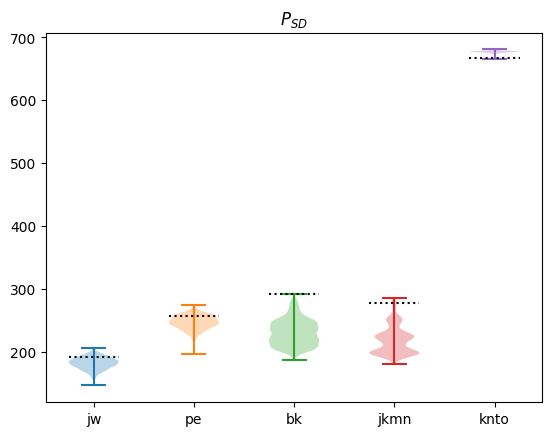

In [47]:
import matplotlib.pyplot as plt

#create histogram
n_bins = 30
alpha = 0.7

fig, axs = plt.subplots()
pos = 0
for dist in distributions.values():
    axs.violinplot(dist, [pos])
    pos+=1
for pos, encoding in enumerate(naive):
    axs.hlines(naive[encoding],  pos-0.25, pos+0.25,  linestyles=":", color="black")
plt.title("$P_{SD}$")
axs.set_xticks([*range(len(distributions))], labels=distributions.keys())
plt.show()

Since k-NTO performs so much worse, let's remove it to look at the others more closely.

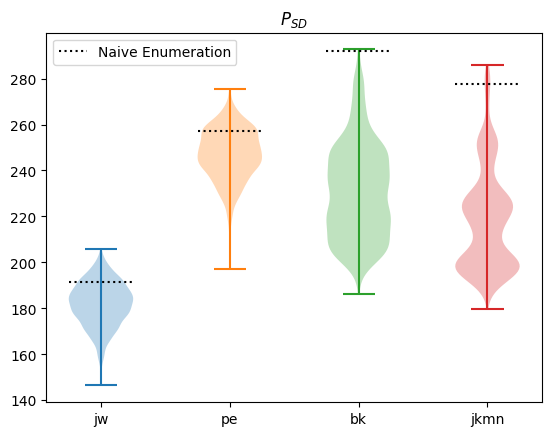

In [46]:
import matplotlib.pyplot as plt

#create histogram
n_bins = 30
alpha = 0.7

fig, axs = plt.subplots()
pos = 0
for dist in [v for k,v in distributions.items() if k != "MaxNTO"]:
    axs.violinplot(dist, [pos])
    pos+=1
for pos, encoding in enumerate(naive):
    if encoding == "MaxNTO":
        continue
    axs.hlines(naive[encoding],  pos-0.25, pos+0.25,  linestyles=":", color="black")

naive_line = mlines.Line2D([], [], color='black', linestyle=":", label="Naive Enumeration")
axs.legend(handles=[naive_line])

    
plt.title("$P_{SD}$")
axs.set_xticks([*range(len(distributions)-1)], labels=[*distributions.keys()][:-1])
plt.show()

The naive enumeration seems to generally be one of the worst options for us here.

Let's try a numerical approach to optimise this.

## Evolutionary Optimisation

Using the `lambda_plus_mu` evolutionary algorithm, we can quickly find an enumeration which has a near-minimal Pauli-weight.

In [30]:
def run_evolutionary(template):
    evaluate = functools.partial(fill_template_find_norm, template, ones, twos)
    best, logbook = lambda_plus_mu(14, evaluate, 150, 5)
    return logbook[-1]["min"], best

In [31]:
evo_best = {}
for encoding,  template in templates.items():
    if encoding == "MaxNTO":
        continue
    evo_best[encoding] = run_evolutionary(template)

/Users/michaelwilliamsdelabastida/Code/ferrmion/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/michaelwilliamsdelabastida/Code/ferrmion/.venv/lib/python3.13/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Finally, we can regenerate the plot above, but with the best permutation found plotted with a dotted line.

<>:16: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\l'
/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_74338/2071930403.py:16: SyntaxWarning: invalid escape sequence '\l'
  evo_line = mlines.Line2D([], [], color='black', linestyle="--", label="$\lambda+\mu$ Evolutionary")


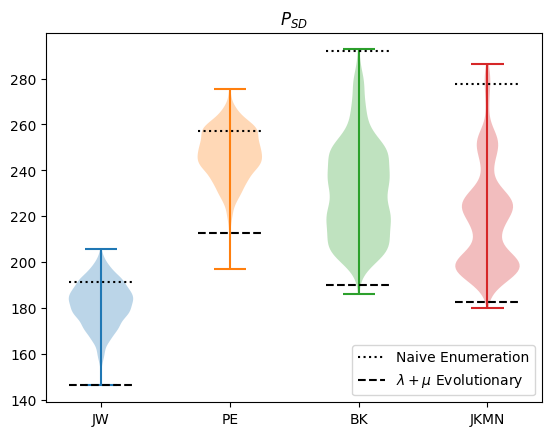

In [48]:
fig, axs = plt.subplots()
pos = 0
for encoding, dist in distributions.items():
    if encoding == "MaxNTO":
        continue
    axs.violinplot(dist, [pos])
    pos+=1
axs.set_xticks([*range(len(distributions)-1)], labels=["JW", "PE", "BK", "JKMN"])
for pos, encoding in enumerate(naive):
    if encoding == "MaxNTO":
        continue
    axs.hlines(naive[encoding],  pos-0.25, pos+0.25,  linestyles=":", color="black")
    axs.hlines(evo_best[encoding][0],  pos-0.25, pos+0.25,  linestyles="--", color="black")

naive_line = mlines.Line2D([], [], color='black', linestyle=":", label="Naive Enumeration")
evo_line = mlines.Line2D([], [], color='black', linestyle="--", label="$\lambda+\mu$ Evolutionary")
axs.legend(handles=[naive_line, evo_line])

plt.title("$P_{SD}$")
plt.show()

## Simulated Annealing

Enumerations can also be optimised with simulated annealing. 

We just need to provide a temperature (using the number of modes tends to give good results) and an initial permutation.

In [ ]:
from ferrmion.core import anneal_enumerations

temp = 14
annealed_best = {}
for encoding in evo_best.keys():
    annealed_best[encoding] = anneal_enumerations(templates[encoding], ones, 0.5*twos, temp, np.array([*range(14)],dtype=np.uint))

<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:18: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\ '
/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_74338/3676380842.py:18: SyntaxWarning: invalid escape sequence '\l'
  evo_line = mlines.Line2D([], [], color='black', linestyle="--", label="$\lambda+\mu$ Evolutionary")
/var/folders/b6/r25qxhld1ls1sll052q1dw5h0000gn/T/ipykernel_74338/3676380842.py:22: SyntaxWarning: invalid escape sequence '\ '
  plt.title("$P_{SD}: H_{2}O\ STO-3G$")


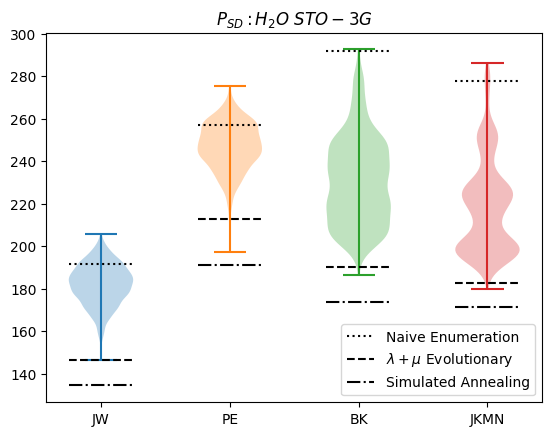

In [ ]:
fig, axs = plt.subplots()
pos = 0
for encoding, dist in distributions.items():
    if encoding == "MaxNTO":
        continue
    axs.violinplot(dist, [pos])
    pos+=1
axs.set_xticks([*range(len(distributions)-1)], labels=["JW", "PE", "BK", "JKMN"])
for pos, encoding in enumerate(naive):
    if encoding == "MaxNTO":
        continue
    axs.hlines(naive[encoding],  pos-0.25, pos+0.25,  linestyles=":", color="black")
    axs.hlines(evo_best[encoding][0],  pos-0.25, pos+0.25,  linestyles="--", color="black")
    axs.hlines(annealed_best[encoding][0],  pos-0.25, pos+0.25,  linestyles="-.", color="black")

naive_line = mlines.Line2D([], [], color='black', linestyle=":", label="Naive Enumeration")
evo_line = mlines.Line2D([], [], color='black', linestyle="--", label="$\lambda+\mu$ Evolutionary")
anneal_line = mlines.Line2D([], [], color='black', linestyle="-.", label="Simulated Annealing")
axs.legend(handles=[naive_line, evo_line, anneal_line])

plt.title("$P_{SD}: H_{2}O\ STO-3G$")
plt.show()

In [34]:
evo_best

{'jw': (np.float64(146.36764082741203),
  array([ 7, 11, 12,  4,  3,  1,  9,  5, 13, 10,  0,  8,  2,  6])),
 'pe': (np.float64(212.88570614495399),
  array([ 1,  4, 12,  8,  5,  7,  3, 13, 11,  9, 10,  2,  6,  0])),
 'bk': (np.float64(190.09338965501377),
  array([ 2,  5, 11, 10,  3, 12,  9, 13,  1,  8,  7,  4,  6,  0])),
 'jkmn': (np.float64(182.50995639552139),
  array([11,  7,  2, 13,  4,  6,  3,  8,  9, 10,  1,  5,  0, 12]))}

In [35]:
annealed_best

{'jw': (134.38833077491117,
  array([ 8,  9,  0,  6, 10,  2,  7, 11,  3,  1,  5, 13,  4, 12],
        dtype=uint64)),
 'pe': (191.1124313988868,
  array([ 8,  9,  1,  3, 11,  7, 12,  4, 13,  5,  2, 10,  6,  0],
        dtype=uint64)),
 'bk': (173.77747829712789,
  array([ 9, 10,  3,  5, 11,  2, 12,  8,  7,  1,  0,  6,  4, 13],
        dtype=uint64)),
 'jkmn': (171.25961274473704,
  array([13, 10, 12, 11,  6,  0,  8,  9,  4,  5,  7,  3,  1,  2],
        dtype=uint64))}